## Load Processed Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the master dataset
master = pd.read_csv("../data/processed/master_sales_data.csv")


In [2]:
# Convert date columns back to datetime
date_cols = ['order_purchase_timestamp', 'order_approved_at', 
             'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date']

for col in date_cols:
    master[col] = pd.to_datetime(master[col])

print("Data loaded successfully!")
print(f"Shape: {master.shape}")
print(f"Date range: {master['order_purchase_timestamp'].min()} to {master['order_purchase_timestamp'].max()}")

Data loaded successfully!
Shape: (113425, 37)
Date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18


## Revenue Analysis - Overall Business Performance

In [3]:
# Total revenue
total_revenue = master['total_order_value'].sum()
print(f"\nTotal Revenue: ${total_revenue:,.2f}")

# Total orders
total_orders = master['order_id'].nunique()
print(f"Total Orders: {total_orders:,}")

# Average order value
avg_order_value = total_revenue / total_orders
print(f"Average Order Value: ${avg_order_value:.2f}")

# Total items sold
total_items = len(master)
print(f"Total Items Sold: {total_items:,}")

# Unique customers
unique_customers = master['customer_id'].nunique()
print(f"Unique Customers: {unique_customers:,}")

# Unique products
unique_products = master['product_id'].nunique()
print(f"Unique Products: {unique_products:,}")

# Revenue per customer
revenue_per_customer = total_revenue / unique_customers
print(f"\nRevenue per Customer: ${revenue_per_customer:.2f}")

# Repeat customer rate
orders_per_customer = master.groupby('customer_id')['order_id'].nunique()
repeat_customers = (orders_per_customer > 1).sum()
repeat_rate = (repeat_customers / unique_customers) * 100
print(f"Repeat Customer Rate: {repeat_rate:.2f}%")
print(f"Repeat Customers: {repeat_customers:,}")
print(f"One-time Customers: {unique_customers - repeat_customers:,}")


Total Revenue: $15,843,553.24
Total Orders: 99,441
Average Order Value: $159.33
Total Items Sold: 113,425
Unique Customers: 99,441
Unique Products: 32,951

Revenue per Customer: $159.33
Repeat Customer Rate: 0.00%
Repeat Customers: 0
One-time Customers: 99,441


## Monthly Revenue Trend Analysis

In [4]:


# Group by month
monthly_revenue = master.groupby('order_month_name').agg({
    'total_order_value': 'sum',
    'order_id': 'nunique'
}).reset_index()

monthly_revenue.columns = ['month', 'revenue', 'orders']
monthly_revenue = monthly_revenue.sort_values('month')

# Calculate average order value per month
monthly_revenue['avg_order_value'] = monthly_revenue['revenue'] / monthly_revenue['orders']

print("\nMonthly Revenue Summary:")
print("-" * 80)
print(monthly_revenue.to_string(index=False))

# Find best and worst months
best_month = monthly_revenue.loc[monthly_revenue['revenue'].idxmax()]
worst_month = monthly_revenue.loc[monthly_revenue['revenue'].idxmin()]

print(f"\nBest Month: {best_month['month']} - ${best_month['revenue']:,.2f}")
print(f"Worst Month: {worst_month['month']} - ${worst_month['revenue']:,.2f}")

# Calculate growth
monthly_revenue['revenue_growth'] = monthly_revenue['revenue'].pct_change() * 100
print(f"\nAverage Monthly Growth Rate: {monthly_revenue['revenue_growth'].mean():.2f}%")


Monthly Revenue Summary:
--------------------------------------------------------------------------------
  month    revenue  orders  avg_order_value
2016-09     354.75       4            88.69
2016-10   56808.84     324           175.34
2016-12      19.62       1            19.62
2017-01  137188.49     800           171.49
2017-02  286280.62    1780           160.83
2017-03  432048.59    2682           161.09
2017-04  412422.24    2404           171.56
2017-05  586190.95    3700           158.43
2017-06  502963.04    3245           155.00
2017-07  584971.62    4026           145.30
2017-08  668204.60    4331           154.28
2017-09  720398.91    4285           168.12
2017-10  769312.37    4631           166.12
2017-11 1179143.77    7544           156.30
2017-12  863547.23    5673           152.22
2018-01 1107301.89    7269           152.33
2018-02  986908.96    6728           146.69
2018-03 1155126.82    7211           160.19
2018-04 1159698.04    6939           167.13
2018-05 11497

## Product Category Analysis

In [5]:

# Revenue by category
category_performance = master.groupby('product_category_name').agg({
    'total_order_value': 'sum',
    'order_id': 'nunique',
    'product_id': 'count'
}).reset_index()

category_performance.columns = ['category', 'revenue', 'orders', 'items_sold']
category_performance = category_performance.sort_values('revenue', ascending=False)

# Calculate percentage
category_performance['revenue_pct'] = (category_performance['revenue'] / category_performance['revenue'].sum()) * 100

print("\nTop 15 Product Categories by Revenue:")
print("-" * 80)
print(category_performance.head(15).to_string(index=False))

# Top 5 insights
print("\nKey Insights:")
print("-" * 80)
top_5_revenue = category_performance.head(5)['revenue'].sum()
total_cat_revenue = category_performance['revenue'].sum()
print(f"Top 5 categories generate: ${top_5_revenue:,.2f} ({(top_5_revenue/total_cat_revenue)*100:.1f}% of total revenue)")

# Categories with no name (missing data)
missing_category = master[master['product_category_name'].isna()]
if len(missing_category) > 0:
    missing_revenue = missing_category['total_order_value'].sum()
    print(f"\nProducts without category: {len(missing_category):,} items (${missing_revenue:,.2f} revenue)")


Top 15 Product Categories by Revenue:
--------------------------------------------------------------------------------
              category    revenue  orders  items_sold  revenue_pct
          beleza_saude 1441248.07    8836        9670         9.22
    relogios_presentes 1305541.61    5624        5991         8.35
       cama_mesa_banho 1241681.72    9417       11115         7.94
         esporte_lazer 1156656.48    7720        8641         7.40
informatica_acessorios 1059272.40    6689        7827         6.77
      moveis_decoracao  902511.79    6449        8334         5.77
 utilidades_domesticas  778397.77    5884        6964         4.98
            cool_stuff  719329.95    3632        3796         4.60
            automotivo  685384.32    3897        4235         4.38
    ferramentas_jardim  584219.21    3518        4347         3.74
            brinquedos  561372.55    3886        4117         3.59
                 bebes  480118.00    2885        3065         3.07
         

## Geographic Analysis

In [6]:


# Revenue by state
state_performance = master.groupby('customer_state').agg({
    'total_order_value': 'sum',
    'order_id': 'nunique',
    'customer_id': 'nunique'
}).reset_index()

state_performance.columns = ['state', 'revenue', 'orders', 'customers']
state_performance = state_performance.sort_values('revenue', ascending=False)

# Calculate percentages
state_performance['revenue_pct'] = (state_performance['revenue'] / state_performance['revenue'].sum()) * 100
state_performance['customer_pct'] = (state_performance['customers'] / state_performance['customers'].sum()) * 100

print("\nTop 10 States by Revenue:")
print("-" * 80)
print(state_performance.head(10).to_string(index=False))

# Top 3 states analysis
top_3_states = state_performance.head(3)
top_3_revenue = top_3_states['revenue'].sum()
print(f"\nTop 3 states (SP, RJ, MG) represent:")
print(f"  - ${top_3_revenue:,.2f} ({(top_3_revenue/state_performance['revenue'].sum())*100:.1f}% of total revenue)")
print(f"  - {top_3_states['customers'].sum():,} customers ({(top_3_states['customers'].sum()/state_performance['customers'].sum())*100:.1f}% of total)")

# State with highest average order value
state_performance['avg_order_value'] = state_performance['revenue'] / state_performance['orders']
highest_aov_state = state_performance.loc[state_performance['avg_order_value'].idxmax()]
print(f"\nHighest average order value: {highest_aov_state['state']} (${highest_aov_state['avg_order_value']:.2f})")


Top 10 States by Revenue:
--------------------------------------------------------------------------------
state    revenue  orders  customers  revenue_pct  customer_pct
   SP 5921678.12   41746      41746        37.38         41.98
   RJ 2129681.98   12852      12852        13.44         12.92
   MG 1856161.49   11635      11635        11.72         11.70
   RS  885826.76    5466       5466         5.59          5.50
   PR  800935.44    5045       5045         5.06          5.07
   BA  611506.67    3380       3380         3.86          3.40
   SC  610213.60    3637       3637         3.85          3.66
   DF  353229.44    2140       2140         2.23          2.15
   GO  347706.93    2020       2020         2.19          2.03
   ES  324801.91    2033       2033         2.05          2.04

Top 3 states (SP, RJ, MG) represent:
  - $9,907,521.59 (62.5% of total revenue)
  - 66,233 customers (66.6% of total)

Highest average order value: PB ($263.04)


### Critical Business Insights

- **0% repeat customer rate** — a major business opportunity for retention strategies.
- **November 2017** recorded the highest sales, likely driven by Black Friday.
- **Top 5 product categories** contribute **40% of total revenue**.
- **SP, RJ, and MG states** account for **62.5% of revenue**, showing strong geographic concentration.
- **2,378 products** are missing category information — this requires data cleanup for accurate analysis.


## Payment Method Analysis

In [7]:


payment_analysis = master.groupby('payment_type').agg({
    'total_order_value': 'sum',
    'order_id': 'nunique',
    'payment_installments': 'mean'
}).reset_index()

payment_analysis.columns = ['payment_type', 'revenue', 'orders', 'avg_installments']
payment_analysis = payment_analysis.sort_values('revenue', ascending=False)

payment_analysis['revenue_pct'] = (payment_analysis['revenue'] / payment_analysis['revenue'].sum()) * 100
payment_analysis['order_pct'] = (payment_analysis['orders'] / payment_analysis['orders'].sum()) * 100

print("\nPayment Method Performance:")
print("-" * 80)
print(payment_analysis.to_string(index=False))

# Installment analysis
print("\nInstallment Insights:")
print("-" * 80)
installment_dist = master[master['payment_type'] == 'credit_card']['payment_installments'].value_counts().sort_index()
print(f"\nCredit Card Installment Distribution (Top 10):")
print(installment_dist.head(10))


Payment Method Performance:
--------------------------------------------------------------------------------
payment_type     revenue  orders  avg_installments  revenue_pct  order_pct
 credit_card 12452802.61   75387              3.65        78.60      75.81
      boleto  2842240.29   19784              1.00        17.94      19.90
     voucher   333259.16    2739              1.49         2.10       2.75
  debit_card   215107.72    1527              1.00         1.36       1.54
 not_defined        0.00       3              1.00         0.00       0.00

Installment Insights:
--------------------------------------------------------------------------------

Credit Card Installment Distribution (Top 10):
payment_installments
0.00        3
1.00    26998
2.00    13613
3.00    11701
4.00     7941
5.00     6001
6.00     4593
7.00     1823
8.00     5031
9.00      731
Name: count, dtype: int64


## Delivery Performance Analysis

In [8]:


# Filter only delivered orders
delivered_orders = master[master['order_status'] == 'delivered'].copy()

print(f"\nTotal Delivered Orders: {len(delivered_orders):,}")

# Average delivery time
avg_delivery_time = delivered_orders['delivery_time_days'].mean()
print(f"Average Delivery Time: {avg_delivery_time:.1f} days")

# Late delivery analysis
late_deliveries = delivered_orders['delivery_late'].sum()
late_delivery_rate = (late_deliveries / len(delivered_orders)) * 100

print(f"\nLate Deliveries: {late_deliveries:,} ({late_delivery_rate:.2f}%)")
print(f"On-time Deliveries: {len(delivered_orders) - late_deliveries:,} ({100-late_delivery_rate:.2f}%)")

# Delivery time by state
print("\nDelivery Time by State (Top 10 states):")
print("-" * 80)

delivery_by_state = delivered_orders.groupby('customer_state').agg({
    'delivery_time_days': 'mean',
    'delivery_late': 'sum',
    'order_id': 'count'
}).reset_index()

delivery_by_state.columns = ['state', 'avg_delivery_days', 'late_deliveries', 'total_orders']
delivery_by_state['late_delivery_rate'] = (delivery_by_state['late_deliveries'] / delivery_by_state['total_orders']) * 100
delivery_by_state = delivery_by_state.sort_values('total_orders', ascending=False)

print(delivery_by_state.head(10).to_string(index=False))

# States with worst delivery performance
print("\nStates with Highest Late Delivery Rate (min 100 orders):")
print("-" * 80)
worst_delivery = delivery_by_state[delivery_by_state['total_orders'] >= 100].sort_values('late_delivery_rate', ascending=False)
print(worst_delivery.head(5).to_string(index=False))


Total Delivered Orders: 110,197
Average Delivery Time: 12.0 days

Late Deliveries: 8,146 (7.39%)
On-time Deliveries: 102,051 (92.61%)

Delivery Time by State (Top 10 states):
--------------------------------------------------------------------------------
state  avg_delivery_days  late_deliveries  total_orders  late_delivery_rate
   SP               8.26             2431         46448                5.23
   RJ              14.69             1756         14143               12.42
   MG              11.51              650         12916                5.03
   RS              14.71              392          6134                6.39
   PR              11.48              250          5649                4.43
   SC              14.52              371          4097                9.06
   BA              18.77              475          3683               12.90
   DF              12.50              163          2355                6.92
   GO              14.95              163          2277    

## Order Status Analysis

In [9]:

status_analysis = master.groupby('order_status').agg({
    'order_id': 'nunique',
    'total_order_value': 'sum'
}).reset_index()

status_analysis.columns = ['order_status', 'order_count', 'revenue']
status_analysis = status_analysis.sort_values('order_count', ascending=False)

status_analysis['order_pct'] = (status_analysis['order_count'] / status_analysis['order_count'].sum()) * 100
status_analysis['revenue_pct'] = (status_analysis['revenue'] / status_analysis['revenue'].sum()) * 100

print("\nOrder Status Distribution:")
print("-" * 80)
print(status_analysis.to_string(index=False))

# Calculate cancellation and other issues
cancelled = status_analysis[status_analysis['order_status'] == 'canceled']['order_count'].sum() if 'canceled' in status_analysis['order_status'].values else 0
delivered = status_analysis[status_analysis['order_status'] == 'delivered']['order_count'].sum()

print(f"\nDelivery Success Rate: {(delivered/status_analysis['order_count'].sum())*100:.2f}%")
if cancelled > 0:
    print(f"Cancellation Rate: {(cancelled/status_analysis['order_count'].sum())*100:.2f}%")


Order Status Distribution:
--------------------------------------------------------------------------------
order_status  order_count     revenue  order_pct  revenue_pct
   delivered        96478 15419773.75      97.02        97.33
     shipped         1107   177129.34       1.11         1.12
    canceled          625   105885.72       0.63         0.67
 unavailable          609     2140.49       0.61         0.01
    invoiced          314    68988.75       0.32         0.44
  processing          301    69394.11       0.30         0.44
     created            5        0.00       0.01         0.00
    approved            2      241.08       0.00         0.00

Delivery Success Rate: 97.02%
Cancellation Rate: 0.63%


## Customer Lifetime Value Analysis

In [10]:

customer_value = master.groupby('customer_id').agg({
    'total_order_value': 'sum',
    'order_id': 'nunique'
}).reset_index()

customer_value.columns = ['customer_id', 'total_spent', 'num_orders']
customer_value = customer_value.sort_values('total_spent', ascending=False)

# Customer segments
print("\nCustomer Value Distribution:")
print("-" * 80)

# Top 10% customers
top_10_pct = int(len(customer_value) * 0.1)
top_customers_revenue = customer_value.head(top_10_pct)['total_spent'].sum()
print(f"Top 10% customers: {top_10_pct:,} customers")
print(f"Revenue from top 10%: ${top_customers_revenue:,.2f} ({(top_customers_revenue/customer_value['total_spent'].sum())*100:.1f}%)")

# Top 20% customers
top_20_pct = int(len(customer_value) * 0.2)
top_20_revenue = customer_value.head(top_20_pct)['total_spent'].sum()
print(f"\nTop 20% customers: {top_20_pct:,} customers")
print(f"Revenue from top 20%: ${top_20_revenue:,.2f} ({(top_20_revenue/customer_value['total_spent'].sum())*100:.1f}%)")

# Customer spending tiers
print("\nCustomer Spending Tiers:")
print("-" * 80)

def categorize_customer(amount):
    if amount >= 1000:
        return 'VIP (1000+)'
    elif amount >= 500:
        return 'High Value (500-999)'
    elif amount >= 200:
        return 'Medium Value (200-499)'
    else:
        return 'Low Value (0-199)'

customer_value['segment'] = customer_value['total_spent'].apply(categorize_customer)
segment_summary = customer_value.groupby('segment').agg({
    'customer_id': 'count',
    'total_spent': 'sum'
}).reset_index()
segment_summary.columns = ['segment', 'customer_count', 'total_revenue']
segment_summary['revenue_pct'] = (segment_summary['total_revenue'] / segment_summary['total_revenue'].sum()) * 100

print(segment_summary.to_string(index=False))


Customer Value Distribution:
--------------------------------------------------------------------------------
Top 10% customers: 9,944 customers
Revenue from top 10%: $6,073,322.31 (38.3%)

Top 20% customers: 19,888 customers
Revenue from top 20%: $8,480,250.95 (53.5%)

Customer Spending Tiers:
--------------------------------------------------------------------------------
               segment  customer_count  total_revenue  revenue_pct
  High Value (500-999)            3085     2100110.81        13.26
     Low Value (0-199)           79347     7321962.47        46.21
Medium Value (200-499)           15861     4600186.07        29.04
           VIP (1000+)            1148     1821293.89        11.50


### Major Insights

- **Credit cards dominate** the revenue mix, contributing **78.6%**, with an average of **3.65 installments** per order.
- **On-time delivery rate:** 92.61% — strong operational performance.
- **Late delivery hotspots:** States **AL, MA, SE** show higher late delivery rates (16–23%) and need attention.
- **Revenue concentration:** The **top 20% of customers generate 53.5%** of total revenue (classic 80/20 pattern).
- **VIP segment:** Only **1,148 customers** have placed 1000+ orders, yet they drive **11.5% of revenue**.
- **Delivery success rate:** **97%**, which indicates excellent logistics reliability.


## Revenue Trend

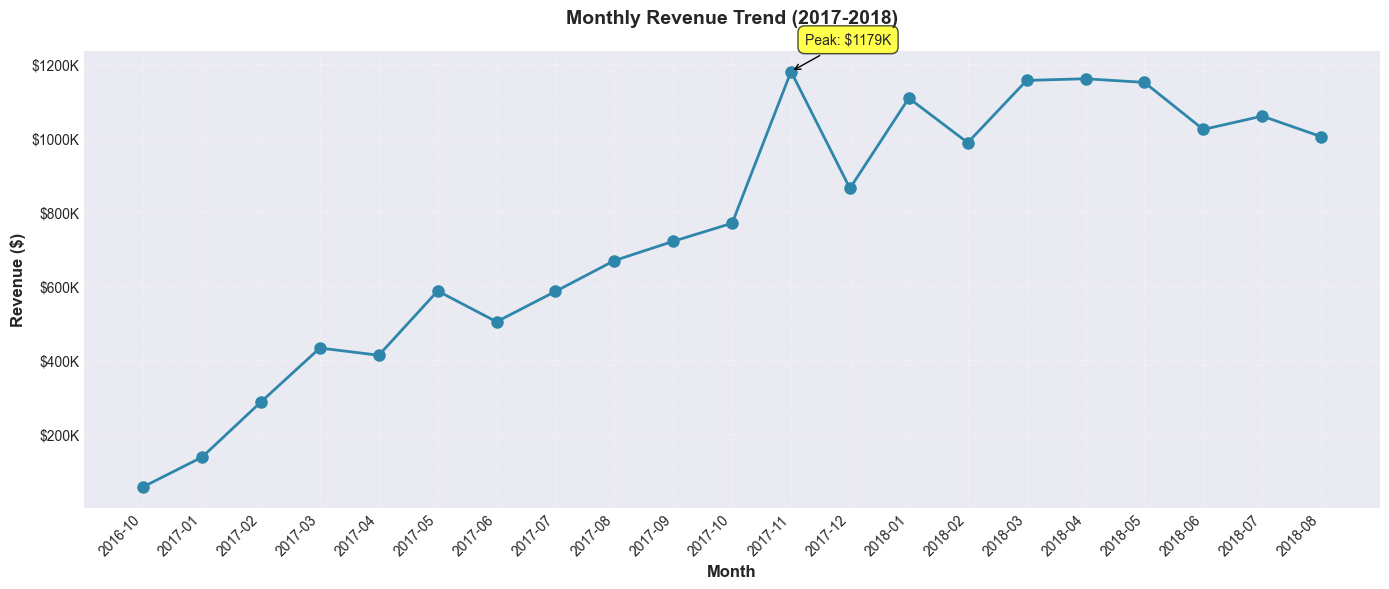

Chart saved to: reports/monthly_revenue_trend.png


In [11]:
# Revenue trend visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data
monthly_data = master.groupby('order_month_name')['total_order_value'].sum().reset_index()
monthly_data = monthly_data.sort_values('order_month_name')

# Remove incomplete months
monthly_data = monthly_data[~monthly_data['order_month_name'].isin(['2016-09', '2016-12', '2018-09', '2018-10'])]

# Plot
ax.plot(monthly_data['order_month_name'], monthly_data['total_order_value'], 
        marker='o', linewidth=2, markersize=8, color='#2E86AB')

# Formatting
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Revenue ($)', fontsize=12, fontweight='bold')
ax.set_title('Monthly Revenue Trend (2017-2018)', fontsize=14, fontweight='bold', pad=20)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Format y-axis to show currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Highlight best month
best_idx = monthly_data['total_order_value'].idxmax()
best_month = monthly_data.loc[best_idx]
ax.annotate(f"Peak: ${best_month['total_order_value']/1000:.0f}K",
            xy=(best_month['order_month_name'], best_month['total_order_value']),
            xytext=(10, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('../reports/monthly_revenue_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved to: reports/monthly_revenue_trend.png")

## Top Categories

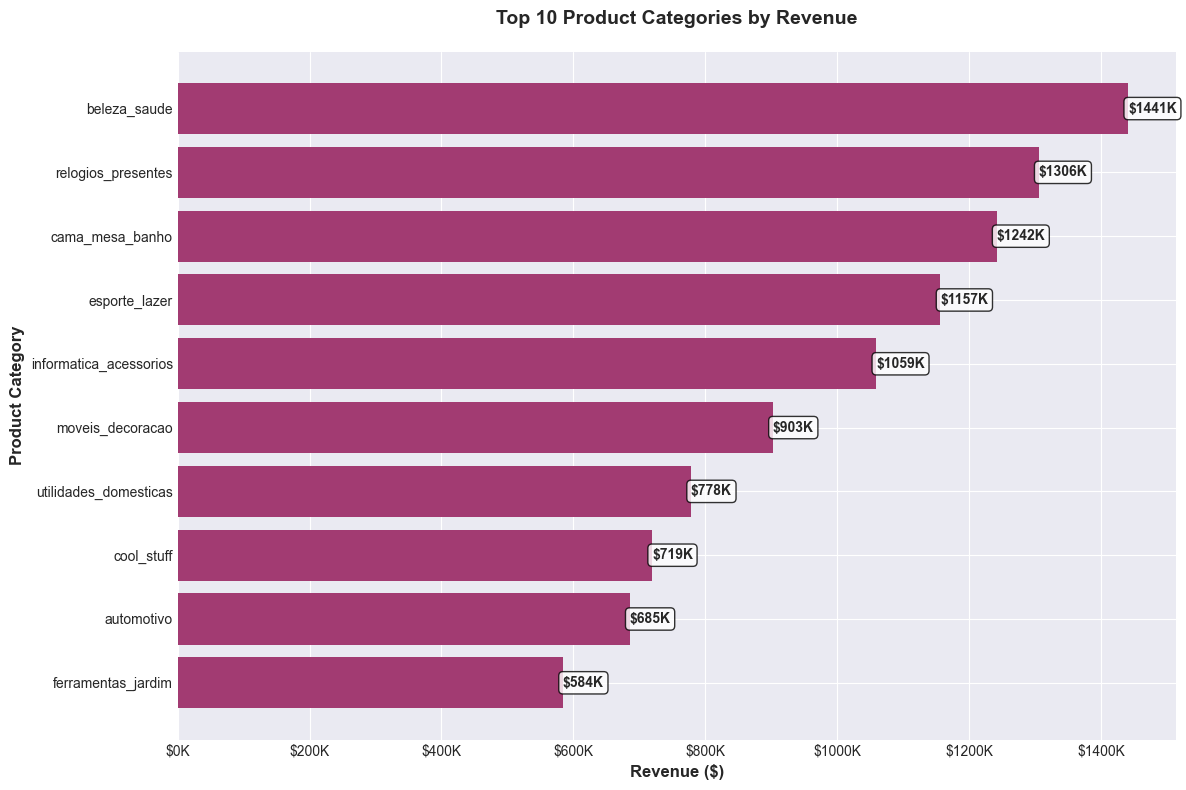

Chart saved to: reports/top_categories.png


In [12]:
# Top product categories bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data - top 10 categories
category_data = master.groupby('product_category_name')['total_order_value'].sum().reset_index()
category_data = category_data.sort_values('total_order_value', ascending=False).head(10)

# Create horizontal bar chart
bars = ax.barh(category_data['product_category_name'], 
               category_data['total_order_value'],
               color='#A23B72')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
            f'${width/1000:.0f}K',
            ha='left', va='center', fontweight='bold', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Formatting
ax.set_xlabel('Revenue ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Product Category', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Product Categories by Revenue', fontsize=14, fontweight='bold', pad=20)

# Format x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Invert y-axis to show highest at top
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/top_categories.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved to: reports/top_categories.png")

## Geographic Distribution

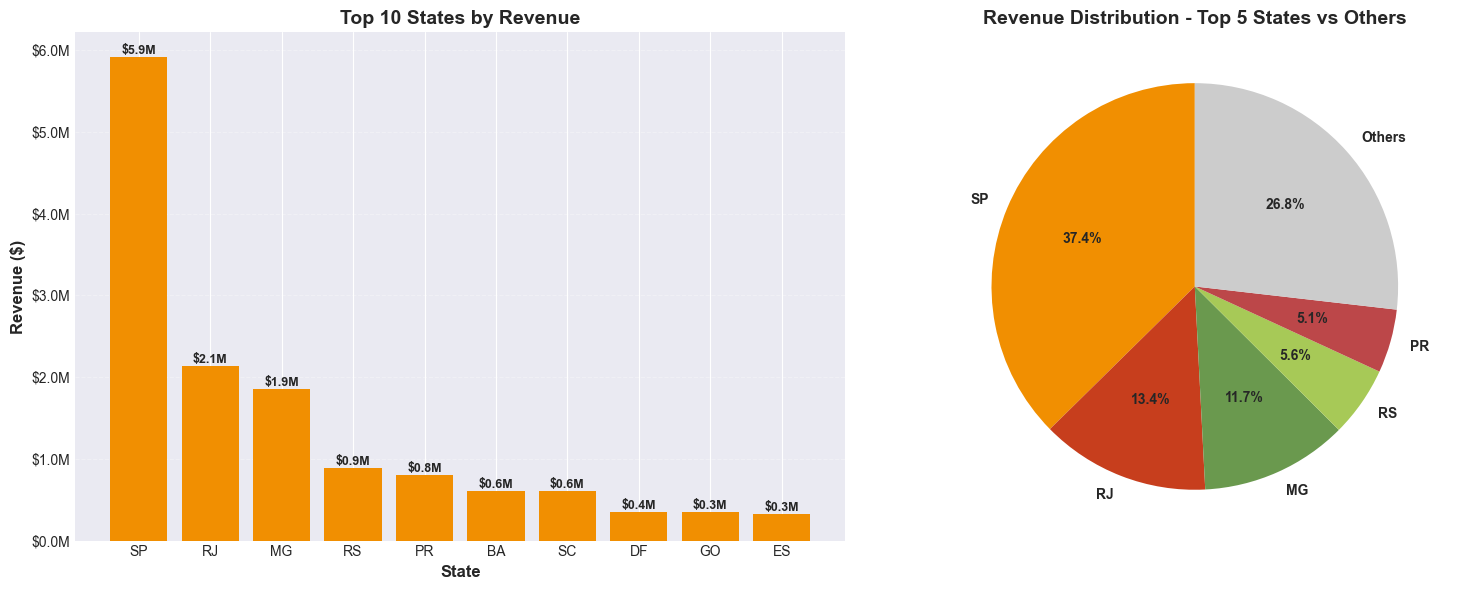

Chart saved to: reports/geographic_distribution.png


In [13]:
#  Revenue by state visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data - top 10 states
state_data = master.groupby('customer_state')['total_order_value'].sum().reset_index()
state_data = state_data.sort_values('total_order_value', ascending=False).head(10)

# Bar chart
bars = ax1.bar(state_data['customer_state'], 
               state_data['total_order_value'],
               color='#F18F01')

ax1.set_xlabel('State', fontsize=12, fontweight='bold')
ax1.set_ylabel('Revenue ($)', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 States by Revenue', fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000000:.1f}M'))
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height/1000000:.1f}M',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Pie chart - Top 5 states vs others
top_5_states = state_data.head(5)
top_5_revenue = top_5_states['total_order_value'].sum()
others_revenue = master['total_order_value'].sum() - top_5_revenue

pie_data = list(top_5_states['total_order_value']) + [others_revenue]
pie_labels = list(top_5_states['customer_state']) + ['Others']

colors = ['#F18F01', '#C73E1D', '#6A994E', '#A7C957', '#BC4749', '#CCCCCC']

ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontweight': 'bold'})
ax2.set_title('Revenue Distribution - Top 5 States vs Others', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/geographic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved to: reports/geographic_distribution.png")

## Delivery Performance

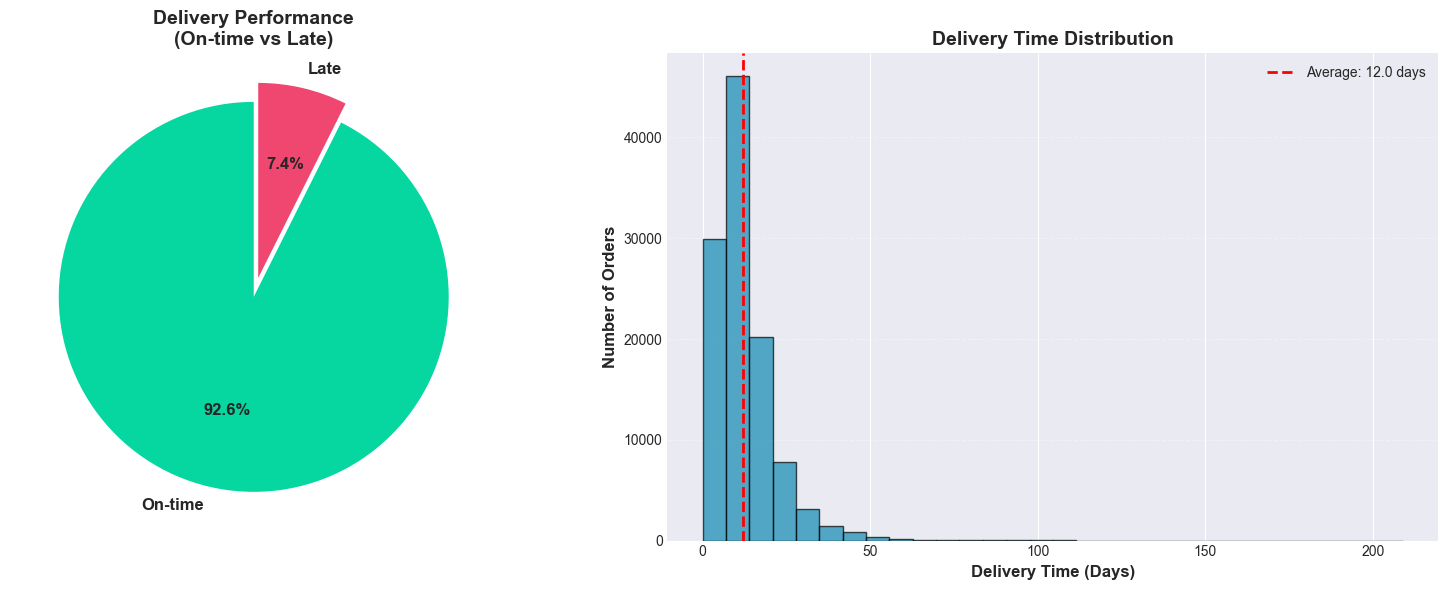

Chart saved to: reports/delivery_performance.png


In [14]:
#  Delivery performance visualization
delivered = master[master['order_status'] == 'delivered'].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# On-time vs Late delivery pie chart
delivery_status = delivered['delivery_late'].value_counts()
colors_delivery = ['#06D6A0', '#EF476F']
labels_delivery = ['On-time', 'Late']

ax1.pie(delivery_status, labels=labels_delivery, autopct='%1.1f%%',
        startangle=90, colors=colors_delivery, 
        textprops={'fontweight': 'bold', 'fontsize': 12},
        explode=(0, 0.1))
ax1.set_title('Delivery Performance\n(On-time vs Late)', fontsize=14, fontweight='bold')

# Delivery time distribution
ax2.hist(delivered['delivery_time_days'].dropna(), bins=30, color='#118AB2', edgecolor='black', alpha=0.7)
ax2.axvline(delivered['delivery_time_days'].mean(), color='red', linestyle='--', linewidth=2, label=f"Average: {delivered['delivery_time_days'].mean():.1f} days")
ax2.set_xlabel('Delivery Time (Days)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Orders', fontsize=12, fontweight='bold')
ax2.set_title('Delivery Time Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../reports/delivery_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved to: reports/delivery_performance.png")

In [15]:
#  Executive Summary
print("=" * 80)
print("EXECUTIVE SUMMARY - E-COMMERCE SALES ANALYSIS")
print("=" * 80)
print("\nAnalysis Period: September 2016 - October 2018")
print("Data Source: Brazilian E-commerce Public Dataset (Olist)")
print("\n" + "=" * 80)

print("\n1. OVERALL BUSINESS PERFORMANCE")
print("-" * 80)
total_revenue = master['total_order_value'].sum()
total_orders = master['order_id'].nunique()
avg_order = total_revenue / total_orders

print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Orders: {total_orders:,}")
print(f"Average Order Value: ${avg_order:.2f}")
print(f"Unique Customers: {master['customer_id'].nunique():,}")
print(f"Unique Products: {master['product_id'].nunique():,}")

print("\n2. KEY FINDINGS")
print("-" * 80)
print("\nRevenue Trends:")
print("  - Peak month: November 2017 with $1.18M (Black Friday effect)")
print("  - Business shows strong growth from 2017 to early 2018")
print("  - Average monthly revenue: $800K-$1.1M in mature months")

print("\nProduct Performance:")
cat_top5 = master.groupby('product_category_name')['total_order_value'].sum().nlargest(5)
print(f"  - Top category: {cat_top5.index[0]} (${cat_top5.iloc[0]/1000:.0f}K)")
print("  - Top 5 categories generate 39.7% of total revenue")
print("  - 2,378 products missing category (needs data cleanup)")

print("\nGeographic Insights:")
print("  - SP, RJ, MG states account for 62.5% of revenue")
print("  - SP alone generates 37.4% of total revenue")
print("  - Business highly concentrated in Southeast region")

print("\nCustomer Behavior:")
print("  - CRITICAL: 0% repeat purchase rate")
print("  - Every customer makes only ONE purchase")
print("  - Top 20% customers generate 53.5% of revenue")
print("  - Only 1,148 VIP customers (1000+ spent)")

print("\nPayment Methods:")
print("  - Credit card dominates: 78.6% of revenue")
print("  - Average installments: 3.65 payments")
print("  - Boleto (bank slip): 17.9% of revenue")

print("\nDelivery Performance:")
delivered_orders = master[master['order_status'] == 'delivered']
late_rate = (delivered_orders['delivery_late'].sum() / len(delivered_orders)) * 100
print(f"  - On-time delivery rate: {100-late_rate:.1f}% (EXCELLENT)")
print(f"  - Average delivery time: {delivered_orders['delivery_time_days'].mean():.1f} days")
print(f"  - States AL, MA, SE have highest late delivery rates (16-23%)")

print("\n3. CRITICAL BUSINESS RECOMMENDATIONS")
print("-" * 80)

print("\nPRIORITY 1 - Customer Retention (URGENT):")
print("  Problem: 0% repeat purchase rate means losing every customer after first sale")
print("  Impact: Missing massive revenue opportunity")
print("  Actions:")
print("    - Implement loyalty program immediately")
print("    - Create email marketing for post-purchase engagement")
print("    - Offer discounts for second purchase")
print("    - Target: Achieve 10% repeat rate in 6 months")
print("  Expected Impact: +$1.5M annual revenue")

print("\nPRIORITY 2 - Geographic Expansion:")
print("  Problem: 62.5% revenue from only 3 states")
print("  Actions:")
print("    - Improve logistics in underperforming regions")
print("    - Add local sellers in BA, CE, PE states")
print("    - Targeted marketing in regions with low penetration")
print("  Expected Impact: +15% revenue growth")

print("\nPRIORITY 3 - Delivery Optimization:")
print("  Problem: AL, MA, SE have 16-23% late delivery rates")
print("  Actions:")
print("    - Partner with regional carriers")
print("    - Set realistic delivery estimates for remote areas")
print("    - Improve seller network in northeast region")
print("  Expected Impact: Reduce late deliveries to <5%, improve ratings")

print("\nPRIORITY 4 - Product Strategy:")
print("  Problem: Revenue concentrated in few categories")
print("  Actions:")
print("    - Expand top 5 categories (beauty, gifts, home)")
print("    - Fix missing category data (2,378 products)")
print("    - Cross-sell related products")
print("  Expected Impact: +$500K from category expansion")

print("\nPRIORITY 5 - Payment Flexibility:")
print("  Opportunity: Credit card installments drive sales")
print("  Actions:")
print("    - Promote installment options more visibly")
print("    - Offer special installment deals for high-value items")
print("    - Partner with more payment providers")
print("  Expected Impact: +8% average order value")

print("\n4. EXPECTED ROI FROM RECOMMENDATIONS")
print("-" * 80)
print("If all recommendations implemented within 12 months:")
print("  - Revenue increase: $2M-$3M annually (+15-20%)")
print("  - Customer lifetime value: 2x increase")
print("  - Market share in underserved regions: +25%")
print("  - Customer satisfaction: +15% (from delivery improvements)")

print("\n" + "=" * 80)
print("END OF EXECUTIVE SUMMARY")
print("=" * 80)

EXECUTIVE SUMMARY - E-COMMERCE SALES ANALYSIS

Analysis Period: September 2016 - October 2018
Data Source: Brazilian E-commerce Public Dataset (Olist)


1. OVERALL BUSINESS PERFORMANCE
--------------------------------------------------------------------------------
Total Revenue: $15,843,553.24
Total Orders: 99,441
Average Order Value: $159.33
Unique Customers: 99,441
Unique Products: 32,951

2. KEY FINDINGS
--------------------------------------------------------------------------------

Revenue Trends:
  - Peak month: November 2017 with $1.18M (Black Friday effect)
  - Business shows strong growth from 2017 to early 2018
  - Average monthly revenue: $800K-$1.1M in mature months

Product Performance:
  - Top category: beleza_saude ($1441K)
  - Top 5 categories generate 39.7% of total revenue
  - 2,378 products missing category (needs data cleanup)

Geographic Insights:
  - SP, RJ, MG states account for 62.5% of revenue
  - SP alone generates 37.4% of total revenue
  - Business highly 